<a href="https://colab.research.google.com/github/Rominaalena/disd_python-datascience-intro/blob/master/Final_version_code_01_04_25.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


Filtered Data:
        city        date   PM10
0     Denver  2023-12-31   1.60
1     Denver  2024-12-31  41.51
2  Vancouver  2023-12-31   1.60
3  Vancouver  2024-12-31  41.51


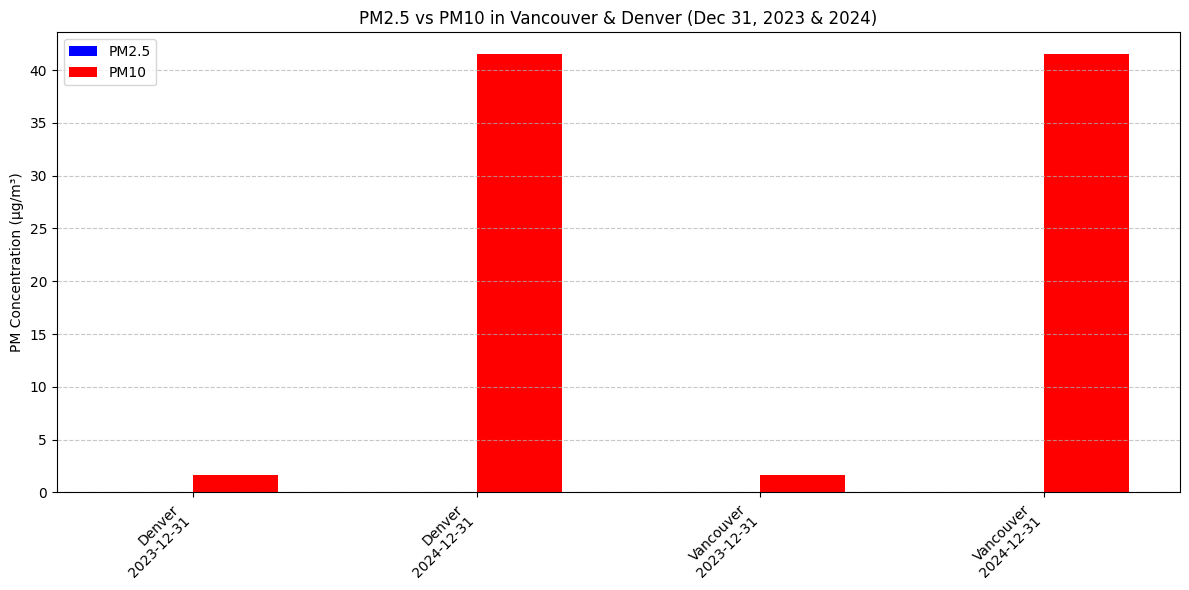

In [30]:
import requests
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime

# API Key
api_key = "e0cd22528d1f3a51cee6cebb84eeb5ffa29eb5961e186aa30ec6401d06aeecf7"

# API URLs for PM2.5 (id=2) and PM10 (id=5) for Vancouver and Denver
url_template = (
    "https://api.openaq.org/v3/parameters/{param_id}/latest?"
    "bbox={bbox}&limit=1000"
)

headers = {
    "X-API-Key": api_key,
    "Accept": "application/json"
}

# Define bounding boxes
bbox_vancouver = "-123.26,49.00,-122.42,49.37"
bbox_denver = "-105.11,39.60,-104.60,39.92"

# Function to fetch and extract measurement data
def fetch_air_quality_data(param_id, city_name, bbox):
    url = url_template.format(param_id=param_id, bbox=bbox)
    response = requests.get(url, headers=headers)
    if response.status_code != 200:
        print(f"Failed to fetch data for {city_name} (Param {param_id})")
        return []

    data = response.json()
    rows = []

    for item in data.get("results", []):
        city = city_name
        location = str(item.get("locationsId"))
        value = item.get("value")
        dt_info = item.get("datetime", {})
        date_str = dt_info.get("utc")
        timestamp = None

        if date_str:
            try:
                timestamp = datetime.fromisoformat(date_str.replace("Z", "+00:00"))
            except Exception:
                pass

        rows.append({
            "city": city,
            "location": location,
            "pollutant": "PM2.5" if param_id == 2 else "PM10",
            "value": value,
            "timestamp": timestamp
        })

    return rows

# Fetch data for both PM2.5 and PM10
vancouver_pm25 = fetch_air_quality_data(2, "Vancouver", bbox_vancouver)
vancouver_pm10 = fetch_air_quality_data(5, "Vancouver", bbox_vancouver)
denver_pm25 = fetch_air_quality_data(2, "Denver", bbox_denver)
denver_pm10 = fetch_air_quality_data(5, "Denver", bbox_denver)

# Combine data into a single DataFrame
df = pd.DataFrame(vancouver_pm25 + vancouver_pm10 + denver_pm25 + denver_pm10)

# Convert timestamps and filter for December 31, 2023, and December 31, 2024
df = df.dropna(subset=["timestamp"])
df["date"] = df["timestamp"].dt.date
df_filtered = df[df["date"].isin([datetime(2023, 12, 31).date(), datetime(2024, 12, 31).date()])]

# Aggregate by city, date, and pollutant (average values if multiple readings)
df_agg = df_filtered.groupby(["city", "date", "pollutant"])["value"].mean().reset_index()

# Pivot table to ensure PM2.5 and PM10 are included
df_pivot = df_agg.pivot(index=["city", "date"], columns="pollutant", values="value").reset_index()

# Ensure missing PM values are explicitly set to 0
df_pivot = df_pivot.rename_axis(None, axis=1).fillna(0)

print("\nFiltered Data:")
print(df_pivot)

# Plot grouped bar chart
fig, ax = plt.subplots(figsize=(12, 6))
width = 0.3  # Width of bars

# Define bar positions
labels = []
x_pos = []
pm25_values = []
pm10_values = []

# Fix column access
for i, row in df_pivot.iterrows():
    labels.append(f"{row['city']}\n{row['date']}")
    x_pos.append(i)
    pm25_values.append(row.get("PM2.5", 0))  # Use .get() to avoid errors
    pm10_values.append(row.get("PM10", 0))

# Create bars
ax.bar([x - width/2 for x in x_pos], pm25_values, width=width, label="PM2.5", color="blue")
ax.bar([x + width/2 for x in x_pos], pm10_values, width=width, label="PM10", color="red")

# Formatting
ax.set_xticks(x_pos)
ax.set_xticklabels(labels, rotation=45, ha="right")
ax.set_ylabel("PM Concentration (µg/m³)")
ax.set_title("PM2.5 vs PM10 in Vancouver & Denver (Dec 31, 2023 & 2024)")
ax.legend()
ax.grid(axis="y", linestyle="--", alpha=0.7)

plt.tight_layout()
plt.show()